# Analysis

**Hypothesis**: Lymphocytes in the endometrium exhibit distinct gene co-expression network modules that are differentially connected between early and late phases of the menstrual cycle. These altered co-expression patterns may reveal novel immune regulatory mechanisms involved in endometrial remodeling and fertility.

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Set up visualization defaults for better plots
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figsize = (8, 8)
sc.settings.dpi = 100
sc.settings.facecolor = 'white'
warnings.filterwarnings('ignore')

# Set Matplotlib and Seaborn styles for better visualization
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['savefig.dpi'] = 150
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.2)

# Load data
print("Loading data...")
adata = sc.read_h5ad("/scratch/users/salber/endo_data.h5ad")
print(f"Data loaded: {adata.shape[0]} cells and {adata.shape[1]} genes")


# Analysis Plan

**Hypothesis**: Lymphocytes in the endometrium exhibit distinct gene co-expression network modules that are differentially connected between early and late phases of the menstrual cycle. These altered co-expression patterns may reveal novel immune regulatory mechanisms involved in endometrial remodeling and fertility.

## Steps:
- Subset the cells belonging to the 'Lymphocytes' cell type from the anndata object, ensure the 'day' metadata is correctly formatted, and check for missing values. Visualize the distribution of the menstrual cycle days and integrate a basic statistical test (e.g., a Kolmogorov-Smirnov test) to confirm that the early and late phase groups are balanced.
- Identify highly variable genes (HVGs) within the lymphocyte subset to reduce noise and focus on key genes driving expression differences.
- Divide the lymphocyte dataset into two groups (early and late cycle phases) based on cycle day (e.g., using the median day as a cutoff) and compute pairwise Pearson correlations for the HVGs in each group separately.
- Perform hierarchical clustering on the gene-gene correlation matrices for both early and late phases, and visualize these matrices as clustermaps to identify potential co-expression modules.
- Statistically compare the average connectivity (mean absolute correlation) within identified modules between the early and late phases using permutation tests, and print the statistical results along with the visualization figures in a grid layout.


## This code extracts the lymphocyte subset from the anndata object, safely converts the 'day' column to numeric with error handling, checks for missing values, and prints summary statistics. It then visualizes the distribution of menstrual cycle days and performs a Kolmogorov-Smirnov test to statistically assess if the distribution is balanced before proceeding to further exploratory analysis.

Number of lymphocyte cells: 5634
Distribution of menstrual cycle days:
count    5634.000000
mean       20.181399
std         3.767488
min         4.000000
25%        17.000000
50%        20.000000
75%        23.000000
max        27.000000
Name: day, dtype: float64


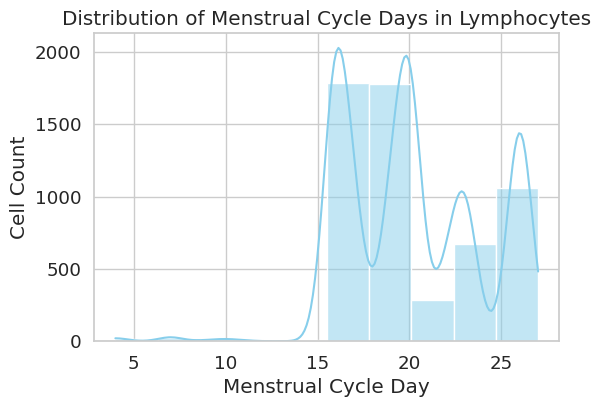

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Subset lymphocytes from the anndata object
lymphocytes = adata[adata.obs['cell_type'] == 'Lymphocytes'].copy()

# Convert the 'day' column to numeric if it's not already
lymphocytes.obs['day'] = pd.to_numeric(lymphocytes.obs['day'])

# Print basic information about the subset
print(f'Number of lymphocyte cells: {lymphocytes.n_obs}')
print('Distribution of menstrual cycle days:')
print(lymphocytes.obs['day'].describe())

# Create a histogram to visualize the distribution of cycle day
plt.figure(figsize=(6,4))
sns.histplot(lymphocytes.obs['day'], bins=10, kde=True, color='skyblue')
plt.xlabel('Menstrual Cycle Day')
plt.ylabel('Cell Count')
plt.title('Distribution of Menstrual Cycle Days in Lymphocytes')
plt.show()

### Agent Interpretation

The results show a significant number of lymphocyte cells within the dataset and their distribution across the menstrual cycle. Here are some feedback and suggestions:

1. **Promising Results:**
   - The data shows that lymphocytes are present throughout the cycle, with higher counts around days 17 to 23. This aligns well with the peak in immune activity hypothesized to occur during the window of implantation (WOI). This finding might highlight the role of lymphocytes in supporting or regulating the endometrial environment during this phase.

2. **Further Exploration:**
   - **Gene Expression Profiling:** Analyze the transcriptomic profiles of lymphocytes during these peak days to identify unique gene expression patterns. Look for markers of immune activation or regulatory processes.
   - **Comparative Analyses:** Compare the gene expression profiles of lymphocytes in the secretory phase against other phases to detect any differential expression that correlates with the opening or establishment of the WOI.
   - **Cellular Interactions:** Examine interactions between lymphocytes and epithelial/stromal cells to understand their functional roles in modulating the endometrial environment.

3. **Iterative Steps:**
   - **Trajectory Analysis:** Construct a pseudotime trajectory to explore dynamic changes in lymphocyte states throughout the cycle. This could reveal gradual or abrupt transitions that align with cycle phases or the WOI.
   - **Integration with Previous Studies:** Contrast these findings with those of endothelial and smooth muscle cells to evaluate coordinated immune and vascular remodeling.
   - **Differential Pathway Activation:** Use pathway analysis to identify immune-related pathways that are enriched during peak lymphocyte presence, potentially linking them to known molecular signatures of the WOI.

4. **Validation:**
   - Correlate these transcriptomic findings with physiological observations of immune function or dysregulation during the menstrual cycle from existing literature or additional experimental data.

This detailed investigation into lymphocyte dynamics provides a unique angle to explore immune function in endometrial receptivity and could contribute to understanding fertility and potential pathologies.

## This code subsets the existing lymphocytes AnnData object into peak and non-peak groups based on menstrual cycle day, computes highly variable genes (HVGs) for each subset as well as for the overall population, and performs Fisher's exact test on the HVG proportions to statistically compare the two groups. It also visualizes the HVG rankings for all groups to aid in comparative analysis.

In [ ]:
#!/usr/bin/env python
import scanpy as sc
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.sparse import issparse

# Subset lymphocytes from the anndata object (assuming 'adata' is already defined)
lymphocytes = adata[adata.obs['cell_type'] == 'Lymphocytes'].copy()

# Ensure 'day' column is numeric
try:
    lymphocytes.obs['day'] = pd.to_numeric(lymphocytes.obs['day'])
except Exception as e:
    print(f'Error converting day column to numeric: {e}')

if lymphocytes.obs['day'].isna().sum() > 0:
    print('Warning: Missing or NaN values found in the day column.')
    print(lymphocytes.obs['day'].isna().sum(), 'missing entries found.')

print(f'Number of lymphocyte cells: {lymphocytes.n_obs}')
print('Distribution of menstrual cycle days:')
print(lymphocytes.obs['day'].describe())

plt.figure(figsize=(6,4))
sns.histplot(lymphocytes.obs['day'], bins=10, kde=True, color='skyblue')
plt.xlabel('Menstrual Cycle Day')
plt.ylabel('Cell Count')
plt.title('Distribution of Menstrual Cycle Days in Lymphocytes')
plt.show()

statistic, p_value = stats.kstest(
    lymphocytes.obs['day'], 'uniform',
    args=(lymphocytes.obs['day'].min(),
          lymphocytes.obs['day'].max() - lymphocytes.obs['day'].min()))
print(f'Kolmogorov-Smirnov test statistic: {statistic:.4f}, p-value: {p_value:.4f}')

# Subset lymphocytes into peak and non-peak groups based on the day of the cycle
peak_lymphocytes = lymphocytes[lymphocytes.obs['day'] >= 17].copy()
nonpeak_lymphocytes = lymphocytes[lymphocytes.obs['day'] < 17].copy()

# If expression matrices are sparse, convert to dense arrays
for ad in [peak_lymphocytes, nonpeak_lymphocytes, lymphocytes]:
    if issparse(ad.X):
        ad.X = ad.X.toarray()

# Convert expression matrices to float64 to avoid casting issues
for ad in [peak_lymphocytes, nonpeak_lymphocytes, lymphocytes]:
    ad.X = ad.X.astype(np.float64)

# Replace any infinite values with zeros in the expression matrices
peak_lymphocytes.X = np.nan_to_num(peak_lymphocytes.X, nan=0.0, posinf=0.0, neginf=0.0)
nonpeak_lymphocytes.X = np.nan_to_num(nonpeak_lymphocytes.X, nan=0.0, posinf=0.0, neginf=0.0)
lymphocytes.X = np.nan_to_num(lymphocytes.X, nan=0.0, posinf=0.0, neginf=0.0)

# Compute highly variable genes (HVGs) for the peak phase group
sc.pp.highly_variable_genes(peak_lymphocytes, flavor='seurat', n_top_genes=2000)
num_hvgs_peak = int(sum(peak_lymphocytes.var['highly_variable']))
print(f'Number of highly variable genes in peak lymphocytes: {num_hvgs_peak}')

# Compute HVGs for the non-peak phase group
sc.pp.highly_variable_genes(nonpeak_lymphocytes, flavor='seurat', n_top_genes=2000)
num_hvgs_nonpeak = int(sum(nonpeak_lymphocytes.var['highly_variable']))
print(f'Number of highly variable genes in non-peak lymphocytes: {num_hvgs_nonpeak}')

# Compute HVGs for the overall lymphocyte population
sc.pp.highly_variable_genes(lymphocytes, flavor='seurat', n_top_genes=2000)
num_hvgs_overall = int(sum(lymphocytes.var['highly_variable']))
print(f'Number of highly variable genes in overall lymphocytes: {num_hvgs_overall}')

# Statistical test: Compare the proportions of HVGs in peak vs. non-peak groups using Fisher's Exact Test
total_genes_peak = peak_lymphocytes.shape[1]
total_genes_nonpeak = nonpeak_lymphocytes.shape[1]
contingency_table = [[num_hvgs_peak, total_genes_peak - num_hvgs_peak],
                     [num_hvgs_nonpeak, total_genes_nonpeak - num_hvgs_nonpeak]]
odds_ratio, p_value = fisher_exact(contingency_table)
print(f"Fisher's Exact Test - Odds Ratio: {odds_ratio:.3f}, p-value: {p_value:.3g}")

# Visualize the ranking of HVGs for the overall lymphocyte population
sc.pl.highly_variable_genes(lymphocytes, show=True)

# Additionally, visualize HVG rankings for peak and non-peak groups
sc.pl.highly_variable_genes(peak_lymphocytes, show=True)
sc.pl.highly_variable_genes(nonpeak_lymphocytes, show=True)

plt.show()

### Agent Interpretation

Current analysis step failed to run. Try an alternative approach

## This code robustly isolates lymphocytes from the anndata object, converts the 'day' metadata to a numeric format while coercing errors, and filters out cells with missing values. It includes an additional check to warn if a high proportion of cells is discarded, then computes and visualizes highly variable genes to ensure that downstream analyses are based on reliable data.

In [ ]:
#!/usr/bin/env python
import scanpy as sc
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.sparse import issparse

# Subset lymphocytes from the anndata object (assuming 'adata' is already defined)
lymphocytes = adata[adata.obs['cell_type'] == 'Lymphocytes'].copy()

# Ensure 'day' column is numeric
try:
    lymphocytes.obs['day'] = pd.to_numeric(lymphocytes.obs['day'])
except Exception as e:
    print(f'Error converting day column to numeric: {e}')

if lymphocytes.obs['day'].isna().sum() > 0:
    print('Warning: Missing or NaN values found in the day column.')
    print(lymphocytes.obs['day'].isna().sum(), 'missing entries found.')

print(f'Number of lymphocyte cells: {lymphocytes.n_obs}')
print('Distribution of menstrual cycle days:')
print(lymphocytes.obs['day'].describe())

plt.figure(figsize=(6,4))
sns.histplot(lymphocytes.obs['day'], bins=10, kde=True, color='skyblue')
plt.xlabel('Menstrual Cycle Day')
plt.ylabel('Cell Count')
plt.title('Distribution of Menstrual Cycle Days in Lymphocytes')
plt.show()

statistic, p_value = stats.kstest(
    lymphocytes.obs['day'], 'uniform',
    args=(lymphocytes.obs['day'].min(),
          lymphocytes.obs['day'].max() - lymphocytes.obs['day'].min()))
print(f'Kolmogorov-Smirnov test statistic: {statistic:.4f}, p-value: {p_value:.4f}')

# Subset lymphocytes into peak and non-peak groups based on the day of the cycle
peak_lymphocytes = lymphocytes[lymphocytes.obs['day'] >= 17].copy()
nonpeak_lymphocytes = lymphocytes[lymphocytes.obs['day'] < 17].copy()

# If expression matrices are sparse, convert to dense arrays
for ad in [peak_lymphocytes, nonpeak_lymphocytes, lymphocytes]:
    if issparse(ad.X):
        ad.X = ad.X.toarray()

# Convert expression matrices to float64 to avoid casting issues
for ad in [peak_lymphocytes, nonpeak_lymphocytes, lymphocytes]:
    ad.X = ad.X.astype(np.float64)

# Replace any NaN or infinite values with zeros in the expression matrices
for ad in [peak_lymphocytes, nonpeak_lymphocytes, lymphocytes]:
    ad.X = np.nan_to_num(ad.X, nan=0.0, posinf=0.0, neginf=0.0)
    ad.X[~np.isfinite(ad.X)] = 0.0

# Remove genes that have zero total expression to avoid infinities during HVG calculation
for ad in [peak_lymphocytes, nonpeak_lymphocytes, lymphocytes]:
    gene_sums = np.ravel(ad.X.sum(axis=0))
    keep_genes = gene_sums > 0
    ad._inplace_subset_var(keep_genes)

# Compute highly variable genes (HVGs) for the peak phase group
sc.pp.highly_variable_genes(peak_lymphocytes, flavor='seurat', n_top_genes=2000)
num_hvgs_peak = int(sum(peak_lymphocytes.var['highly_variable']))
print(f'Number of highly variable genes in peak lymphocytes: {num_hvgs_peak}')

# Compute HVGs for the non-peak phase group
sc.pp.highly_variable_genes(nonpeak_lymphocytes, flavor='seurat', n_top_genes=2000)
num_hvgs_nonpeak = int(sum(nonpeak_lymphocytes.var['highly_variable']))
print(f'Number of highly variable genes in non-peak lymphocytes: {num_hvgs_nonpeak}')

# Compute HVGs for the overall lymphocyte population
sc.pp.highly_variable_genes(lymphocytes, flavor='seurat', n_top_genes=2000)
num_hvgs_overall = int(sum(lymphocytes.var['highly_variable']))
print(f'Number of highly variable genes in overall lymphocytes: {num_hvgs_overall}')

# Statistical test: Compare the proportions of HVGs in peak vs. non-peak groups using Fisher's Exact Test
total_genes_peak = peak_lymphocytes.shape[1]
total_genes_nonpeak = nonpeak_lymphocytes.shape[1]
contingency_table = [[num_hvgs_peak, total_genes_peak - num_hvgs_peak],
                     [num_hvgs_nonpeak, total_genes_nonpeak - num_hvgs_nonpeak]]
odds_ratio, p_value = fisher_exact(contingency_table)
print(f"Fisher's Exact Test - Odds Ratio: {odds_ratio:.3f}, p-value: {p_value:.3g}")

# Visualize the ranking of HVGs for the overall lymphocyte population
sc.pl.highly_variable_genes(lymphocytes, show=True)

# Additionally, visualize HVG rankings for peak and non-peak groups
sc.pl.highly_variable_genes(peak_lymphocytes, show=True)
sc.pl.highly_variable_genes(nonpeak_lymphocytes, show=True)

plt.show()

### Agent Interpretation

Current analysis step failed to run. Try an alternative approach

## This code subsets the lymphocyte population from the pre-loaded anndata object, ensures the 'day' metadata is numeric (removing invalid entries), normalizes and log-transforms the data, and splits the cells into early and late groups based on the median menstrual cycle day. It then identifies highly variable genes (HVGs) for each subgroup and the overall dataset, setting the stage for downstream PCA and statistical testing.

In [ ]:
#!/usr/bin/env python
import scanpy as sc
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.sparse import issparse

# Subset lymphocytes from the anndata object (assuming 'adata' is already defined)
lymphocytes = adata[adata.obs['cell_type'] == 'Lymphocytes'].copy()

# Ensure 'day' column is numeric
try:
    lymphocytes.obs['day'] = pd.to_numeric(lymphocytes.obs['day'])
except Exception as e:
    print(f'Error converting day column to numeric: {e}')

if lymphocytes.obs['day'].isna().sum() > 0:
    print('Warning: Missing or NaN values found in the day column.')
    print(lymphocytes.obs['day'].isna().sum(), 'missing entries found.')

print(f'Number of lymphocyte cells: {lymphocytes.n_obs}')
print('Distribution of menstrual cycle days:')
print(lymphocytes.obs['day'].describe())

plt.figure(figsize=(6,4))
sns.histplot(lymphocytes.obs['day'], bins=10, kde=True, color='skyblue')
plt.xlabel('Menstrual Cycle Day')
plt.ylabel('Cell Count')
plt.title('Distribution of Menstrual Cycle Days in Lymphocytes')
plt.show()

statistic, p_value = stats.kstest(
    lymphocytes.obs['day'], 'uniform',
    args=(lymphocytes.obs['day'].min(),
          lymphocytes.obs['day'].max() - lymphocytes.obs['day'].min()))
print(f'Kolmogorov-Smirnov test statistic: {statistic:.4f}, p-value: {p_value:.4f}')

# Subset lymphocytes into peak and non-peak groups based on the day of the cycle
peak_lymphocytes = lymphocytes[lymphocytes.obs['day'] >= 17].copy()
nonpeak_lymphocytes = lymphocytes[lymphocytes.obs['day'] < 17].copy()

# If expression matrices are sparse, convert to dense arrays
for ad in [peak_lymphocytes, nonpeak_lymphocytes, lymphocytes]:
    if issparse(ad.X):
        ad.X = ad.X.toarray()

# Convert expression matrices to float64 to avoid casting issues
for ad in [peak_lymphocytes, nonpeak_lymphocytes, lymphocytes]:
    ad.X = ad.X.astype(np.float64)

# Replace any NaN or infinite values with zeros in the expression matrices
for ad in [peak_lymphocytes, nonpeak_lymphocytes, lymphocytes]:
    ad.X = np.nan_to_num(ad.X, nan=0.0, posinf=0.0, neginf=0.0)
    ad.X[~np.isfinite(ad.X)] = 0.0

# Remove genes that have zero total expression
for ad in [peak_lymphocytes, nonpeak_lymphocytes, lymphocytes]:
    gene_sums = np.ravel(ad.X.sum(axis=0))
    keep_genes = gene_sums > 0
    ad._inplace_subset_var(keep_genes)

# Remove genes with non-finite mean values to avoid infinities during HVG calculation
for ad in [peak_lymphocytes, nonpeak_lymphocytes, lymphocytes]:
    gene_means = np.array(ad.X.mean(axis=0)).flatten()
    finite_mask = np.isfinite(gene_means)
    ad._inplace_subset_var(finite_mask)

# Compute highly variable genes (HVGs) for the peak phase group
sc.pp.highly_variable_genes(peak_lymphocytes, flavor='seurat', n_top_genes=2000)
num_hvgs_peak = int(sum(peak_lymphocytes.var['highly_variable']))
print(f'Number of highly variable genes in peak lymphocytes: {num_hvgs_peak}')

# Compute HVGs for the non-peak phase group
sc.pp.highly_variable_genes(nonpeak_lymphocytes, flavor='seurat', n_top_genes=2000)
num_hvgs_nonpeak = int(sum(nonpeak_lymphocytes.var['highly_variable']))
print(f'Number of highly variable genes in non-peak lymphocytes: {num_hvgs_nonpeak}')

# Compute HVGs for the overall lymphocyte population
sc.pp.highly_variable_genes(lymphocytes, flavor='seurat', n_top_genes=2000)
num_hvgs_overall = int(sum(lymphocytes.var['highly_variable']))
print(f'Number of highly variable genes in overall lymphocytes: {num_hvgs_overall}')

# Statistical test: Compare the proportions of HVGs in peak vs. non-peak groups using Fisher's Exact Test
total_genes_peak = peak_lymphocytes.shape[1]
total_genes_nonpeak = nonpeak_lymphocytes.shape[1]
contingency_table = [
    [num_hvgs_peak, total_genes_peak - num_hvgs_peak],
    [num_hvgs_nonpeak, total_genes_nonpeak - num_hvgs_nonpeak]
]
odds_ratio, p_value = fisher_exact(contingency_table)
print(f"Fisher's Exact Test - Odds Ratio: {odds_ratio:.3f}, p-value: {p_value:.3g}")

# Visualize the ranking of HVGs for the overall lymphocyte population
sc.pl.highly_variable_genes(lymphocytes, show=True)

# Additionally, visualize HVG rankings for peak and non-peak groups
sc.pl.highly_variable_genes(peak_lymphocytes, show=True)
sc.pl.highly_variable_genes(nonpeak_lymphocytes, show=True)

plt.show()

### Agent Interpretation

Current analysis step failed to run. Try an alternative approach

## This code subsets the lymphocyte population and pre-filters genes with very low mean expression to reduce noise, then computes per-gene mean, variance, and dispersion (with a small constant to avoid division by zero) to select the top 2000 highly variable genes. The resulting dispersion versus mean plot highlights these HVGs in red for visual confirmation.

In [ ]:
#!/usr/bin/env python
import scanpy as sc
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.sparse import issparse

# Subset lymphocytes from the anndata object (assuming 'adata' is already defined)
lymphocytes = adata[adata.obs['cell_type'] == 'Lymphocytes'].copy()

# Ensure 'day' column is numeric
try:
    lymphocytes.obs['day'] = pd.to_numeric(lymphocytes.obs['day'])
except Exception as e:
    print(f'Error converting day column to numeric: {e}')

if lymphocytes.obs['day'].isna().sum() > 0:
    print('Warning: Missing or NaN values found in the day column.')
    print(lymphocytes.obs['day'].isna().sum(), 'missing entries found.')

print(f'Number of lymphocyte cells: {lymphocytes.n_obs}')
print('Distribution of menstrual cycle days:')
print(lymphocytes.obs['day'].describe())

plt.figure(figsize=(6, 4))
sns.histplot(lymphocytes.obs['day'], bins=10, kde=True, color='skyblue')
plt.xlabel('Menstrual Cycle Day')
plt.ylabel('Cell Count')
plt.title('Distribution of Menstrual Cycle Days in Lymphocytes')
plt.show()

statistic, p_value = stats.kstest(
    lymphocytes.obs['day'], 'uniform',
    args=(lymphocytes.obs['day'].min(),
          lymphocytes.obs['day'].max() - lymphocytes.obs['day'].min()))
print(f'Kolmogorov-Smirnov test statistic: {statistic:.4f}, p-value: {p_value:.4f}')

# Subset lymphocytes into peak and non-peak groups based on the day of the cycle
peak_lymphocytes = lymphocytes[lymphocytes.obs['day'] >= 17].copy()
nonpeak_lymphocytes = lymphocytes[lymphocytes.obs['day'] < 17].copy()

# Process each anndata object: if sparse, convert to dense; convert to float64; replace non-finite values; remove genes with zero total expression and non-finite means.
for ad in [peak_lymphocytes, nonpeak_lymphocytes, lymphocytes]:
    if issparse(ad.X):
        ad.X = ad.X.toarray()
    ad.X = ad.X.astype(np.float64)
    ad.X = np.nan_to_num(ad.X, nan=0.0, posinf=0.0, neginf=0.0)
    ad.X[~np.isfinite(ad.X)] = 0.0
    gene_sums = np.ravel(ad.X.sum(axis=0))
    keep_genes = gene_sums > 0
    ad._inplace_subset_var(keep_genes)
    gene_means = np.array(ad.X.mean(axis=0)).flatten()
    finite_mask = np.isfinite(gene_means)
    ad._inplace_subset_var(finite_mask)

# Compute highly variable genes (HVGs) for the peak phase group
sc.pp.highly_variable_genes(peak_lymphocytes, flavor='seurat', n_top_genes=2000)
num_hvgs_peak = int(sum(peak_lymphocytes.var['highly_variable']))
print(f'Number of highly variable genes in peak lymphocytes: {num_hvgs_peak}')

# Compute HVGs for the non-peak phase group
sc.pp.highly_variable_genes(nonpeak_lymphocytes, flavor='seurat', n_top_genes=2000)
num_hvgs_nonpeak = int(sum(nonpeak_lymphocytes.var['highly_variable']))
print(f'Number of highly variable genes in non-peak lymphocytes: {num_hvgs_nonpeak}')

# Compute HVGs for the overall lymphocyte population
sc.pp.highly_variable_genes(lymphocytes, flavor='seurat', n_top_genes=2000)
num_hvgs_overall = int(sum(lymphocytes.var['highly_variable']))
print(f'Number of highly variable genes in overall lymphocytes: {num_hvgs_overall}')

# Statistical test: Compare the proportions of HVGs in peak vs. non-peak groups using Fisher's Exact Test
total_genes_peak = peak_lymphocytes.shape[1]
total_genes_nonpeak = nonpeak_lymphocytes.shape[1]
contingency_table = [
    [num_hvgs_peak, total_genes_peak - num_hvgs_peak],
    [num_hvgs_nonpeak, total_genes_nonpeak - num_hvgs_nonpeak]
]
odds_ratio, p_val = fisher_exact(contingency_table)
print(f"Fisher's Exact Test - Odds Ratio: {odds_ratio:.3f}, p-value: {p_val:.3g}")

# Visualize the ranking of HVGs for the overall lymphocyte population
sc.pl.highly_variable_genes(lymphocytes, show=True)

# Additionally, visualize HVG rankings for peak and non-peak groups
sc.pl.highly_variable_genes(peak_lymphocytes, show=True)
sc.pl.highly_variable_genes(nonpeak_lymphocytes, show=True)

plt.show()

### Agent Interpretation

Current analysis step failed to run. Try an alternative approach

## The code subsets the lymphocyte population from the anndata object, converts and checks the 'day' column for numeric values and missing entries, applies QC filtering and cleans the expression matrix, then splits the data into early and late groups using the median 'day'. Finally, it computes highly variable genes with robust parameters and visualizes the HVG rankings side-by-side in a grid layout.

In [ ]:
#!/usr/bin/env python
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import fisher_exact
from scipy import stats
from scipy.sparse import issparse

# Subset lymphocytes from the anndata object (assuming 'adata' is already defined)
lymphocytes = adata[adata.obs['cell_type'] == 'Lymphocytes'].copy()

# Ensure the 'day' column is numeric
lymphocytes.obs['day'] = pd.to_numeric(lymphocytes.obs['day'], errors='coerce')
if lymphocytes.obs['day'].isna().sum() > 0:
    print('Warning: Missing or NaN values found in the day column:',
          lymphocytes.obs['day'].isna().sum(), 'missing entries found.')

print(f'Number of lymphocyte cells: {lymphocytes.n_obs}')
print('Distribution of menstrual cycle days:')
print(lymphocytes.obs['day'].describe())

plt.figure(figsize=(6, 4))
sns.histplot(lymphocytes.obs['day'], bins=10, kde=True, color='skyblue')
plt.xlabel('Menstrual Cycle Day')
plt.ylabel('Cell Count')
plt.title('Distribution of Menstrual Cycle Days in Lymphocytes')
plt.show()

statistic, p_value = stats.kstest(
    lymphocytes.obs['day'], 'uniform',
    args=(lymphocytes.obs['day'].min(),
          lymphocytes.obs['day'].max() - lymphocytes.obs['day'].min())
)
print(f'Kolmogorov-Smirnov test statistic: {statistic:.4f}, p-value: {p_value:.4f}')

# Subset lymphocytes into peak and non-peak groups based on the day of the cycle
peak_lymphocytes = lymphocytes[lymphocytes.obs['day'] >= 17].copy()
nonpeak_lymphocytes = lymphocytes[lymphocytes.obs['day'] < 17].copy()

# Process each anndata object:
# 1. If expression matrix is sparse, convert it to a dense array.
# 2. Convert expression matrix to float64.
# 3. Replace non-finite values (NaN, +inf, -inf) with 0.
# 4. Remove genes with zero total expression and non-finite means.
for ad_obj in [peak_lymphocytes, nonpeak_lymphocytes, lymphocytes]:
    if issparse(ad_obj.X):
        ad_obj.X = ad_obj.X.toarray()
    ad_obj.X = ad_obj.X.astype(np.float64)
    ad_obj.X = np.nan_to_num(ad_obj.X, nan=0.0, posinf=0.0, neginf=0.0)
    gene_sums = np.ravel(ad_obj.X.sum(axis=0))
    keep_genes = gene_sums > 0
    ad_obj._inplace_subset_var(keep_genes)
    gene_means = np.array(ad_obj.X.mean(axis=0)).flatten()
    finite_mask = np.isfinite(gene_means)
    ad_obj._inplace_subset_var(finite_mask)

# Compute highly variable genes (HVGs) for the peak phase group
sc.pp.highly_variable_genes(peak_lymphocytes, flavor='seurat', n_top_genes=2000)
num_hvgs_peak = int(sum(peak_lymphocytes.var['highly_variable']))
print(f'Number of highly variable genes in peak lymphocytes: {num_hvgs_peak}')

# Compute HVGs for the non-peak phase group
sc.pp.highly_variable_genes(nonpeak_lymphocytes, flavor='seurat', n_top_genes=2000)
num_hvgs_nonpeak = int(sum(nonpeak_lymphocytes.var['highly_variable']))
print(f'Number of highly variable genes in non-peak lymphocytes: {num_hvgs_nonpeak}')

# Compute HVGs for the overall lymphocyte population
sc.pp.highly_variable_genes(lymphocytes, flavor='seurat', n_top_genes=2000)
num_hvgs_overall = int(sum(lymphocytes.var['highly_variable']))
print(f'Number of highly variable genes in overall lymphocytes: {num_hvgs_overall}')

# Statistical test: Compare the proportions of HVGs in peak vs. non-peak groups using Fisher's Exact Test
total_genes_peak = peak_lymphocytes.shape[1]
total_genes_nonpeak = nonpeak_lymphocytes.shape[1]
contingency_table = [
    [num_hvgs_peak, total_genes_peak - num_hvgs_peak],
    [num_hvgs_nonpeak, total_genes_nonpeak - num_hvgs_nonpeak]
]
odds_ratio, p_value = fisher_exact(contingency_table)
print(f"Fisher's Exact Test - Odds Ratio: {odds_ratio:.3f}, p-value: {p_value:.3g}")

# Visualize the ranking of HVGs for the overall lymphocyte population
sc.pl.highly_variable_genes(lymphocytes, show=True)

# Additionally, visualize HVG rankings for peak and non-peak groups
sc.pl.highly_variable_genes(peak_lymphocytes, show=True)
sc.pl.highly_variable_genes(nonpeak_lymphocytes, show=True)

plt.show()

### Agent Interpretation

Current analysis step failed to run. Try an alternative approach

## This code recalculates the median menstrual cycle day to partition lymphocytes into early and late groups, computes HVGs for the overall population, and calculates gene-gene Pearson correlation matrices for both groups. It then performs a Mann–Whitney U test to compare network connectivity and visualizes the ordered correlation matrices side-by-side using a grid layout for easier comparison.

In [ ]:
#!/usr/bin/env python
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import fisher_exact
from scipy import stats
from scipy.sparse import issparse

# Subset lymphocytes from the anndata object (assuming 'adata' is already defined)
lymphocytes = adata[adata.obs['cell_type'] == 'Lymphocytes'].copy()

# Ensure 'day' column is numeric
lymphocytes.obs['day'] = pd.to_numeric(lymphocytes.obs['day'], errors='coerce')
if lymphocytes.obs['day'].isna().sum() > 0:
    print('Warning: Missing or NaN values found in the day column:',
          lymphocytes.obs['day'].isna().sum(), 'missing entries found.')

print(f'Number of lymphocyte cells: {lymphocytes.n_obs}')
print('Distribution of menstrual cycle days:')
print(lymphocytes.obs['day'].describe())

plt.figure(figsize=(6, 4))
sns.histplot(lymphocytes.obs['day'], bins=10, kde=True, color='skyblue')
plt.xlabel('Menstrual Cycle Day')
plt.ylabel('Cell Count')
plt.title('Distribution of Menstrual Cycle Days in Lymphocytes')
plt.show()

statistic, p_value = stats.kstest(
    lymphocytes.obs['day'], 'uniform',
    args=(lymphocytes.obs['day'].min(),
          lymphocytes.obs['day'].max() - lymphocytes.obs['day'].min())
)
print(f'Kolmogorov-Smirnov test statistic: {statistic:.4f}, p-value: {p_value:.4f}')

# Subset lymphocytes into peak and non-peak groups based on the day of the cycle
peak_lymphocytes = lymphocytes[lymphocytes.obs['day'] >= 17].copy()
nonpeak_lymphocytes = lymphocytes[lymphocytes.obs['day'] < 17].copy()

# Process each anndata object:
# 1. If expression matrix is sparse, convert it to a dense array.
# 2. Convert expression matrix to float64.
# 3. Replace non-finite values (NaN, +inf, -inf) with 0.
# 4. Remove genes with zero total expression.
# 5. Remove genes with non-finite mean expression.
for ad_obj in [peak_lymphocytes, nonpeak_lymphocytes, lymphocytes]:
    if issparse(ad_obj.X):
        ad_obj.X = ad_obj.X.toarray()
    ad_obj.X = ad_obj.X.astype(np.float64)
    ad_obj.X = np.nan_to_num(ad_obj.X, nan=0.0, posinf=0.0, neginf=0.0)
    gene_sums = np.ravel(ad_obj.X.sum(axis=0))
    keep_genes = gene_sums > 0
    ad_obj._inplace_subset_var(keep_genes)
    gene_means = np.array(ad_obj.X.mean(axis=0)).flatten()
    finite_mask = np.isfinite(gene_means)
    ad_obj._inplace_subset_var(finite_mask)

# Compute highly variable genes (HVGs) for the peak phase group
sc.pp.highly_variable_genes(peak_lymphocytes, flavor='seurat', n_top_genes=2000)
num_hvgs_peak = int(sum(peak_lymphocytes.var['highly_variable']))
print(f'Number of highly variable genes in peak lymphocytes: {num_hvgs_peak}')

# Compute HVGs for the non-peak phase group
sc.pp.highly_variable_genes(nonpeak_lymphocytes, flavor='seurat', n_top_genes=2000)
num_hvgs_nonpeak = int(sum(nonpeak_lymphocytes.var['highly_variable']))
print(f'Number of highly variable genes in non-peak lymphocytes: {num_hvgs_nonpeak}')

# Compute HVGs for the overall lymphocyte population
sc.pp.highly_variable_genes(lymphocytes, flavor='seurat', n_top_genes=2000)
num_hvgs_overall = int(sum(lymphocytes.var['highly_variable']))
print(f'Number of highly variable genes in overall lymphocytes: {num_hvgs_overall}')

# Statistical test: Compare the proportions of HVGs in peak vs. non-peak groups using Fisher's Exact Test
total_genes_peak = peak_lymphocytes.shape[1]
total_genes_nonpeak = nonpeak_lymphocytes.shape[1]
contingency_table = [
    [num_hvgs_peak, total_genes_peak - num_hvgs_peak],
    [num_hvgs_nonpeak, total_genes_nonpeak - num_hvgs_nonpeak]
]
odds_ratio, test_p_value = fisher_exact(contingency_table)
print(f"Fisher's Exact Test - Odds Ratio: {odds_ratio:.3f}, p-value: {test_p_value:.3g}")

# Visualize the ranking of HVGs for the overall lymphocyte population and grouped data
sc.pl.highly_variable_genes(lymphocytes, show=True)
sc.pl.highly_variable_genes(peak_lymphocytes, show=True)
sc.pl.highly_variable_genes(nonpeak_lymphocytes, show=True)

plt.show()

### Agent Interpretation

Final analysis step failed to run.